# Aim
Characterize the SEAL closed-loop delay and try to build that into the controller.


In [307]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import re
sys.path.append("..")
from src import *
fs = 100

In [308]:
def stamp_to_seconds(t):
    h, m, s, ms = [int(x) for x in re.search("(\d+):(\d+):(\d+),(\d+)", t).groups()]
    return 3600 * h + 60 * m + s + 0.001 * ms

In [325]:
# add 13_11_2021 to these ones
good_runs = ["07_02_14", "07_04_45", "08_11_19", "08_11_46"]

In [326]:
exposures = []
measures = []
dmcs = []

total_nframes = 0
for fname in good_runs:
    with open(joindata("log", f"log_13_11_2021_{fname}.log")) as file:
        final_frame = np.inf
        for line in file:
            time = re.search("\d+:\d+:\d+,\d+", line)[0]
            seconds = stamp_to_seconds(time)
            event = re.search("INFO \| (.+)", line)[1]
            if not any([event.startswith(x) for x in ["Exposure", "Measurement", "DMC"]]):
                continue
            frame_num = re.search("\d+", event)
            if frame_num:
                frame_num = int(frame_num[0])
            if event.startswith("Exposure"):
                exposures.append(seconds)
            elif event.startswith("Measurement"):
                measures.append(seconds)
            elif event.startswith("DMC"):
                dmcs.append(seconds)
                final_frame = frame_num
        total_nframes += final_frame
        exposures = exposures[:total_nframes]
        measures = measures[:total_nframes]
        dmcs = dmcs[:total_nframes]

t0 = exposures[0]
exposures = np.array(exposures) - t0
measures = np.array(measures) - t0
dmcs = np.array(dmcs) - t0

([], [])

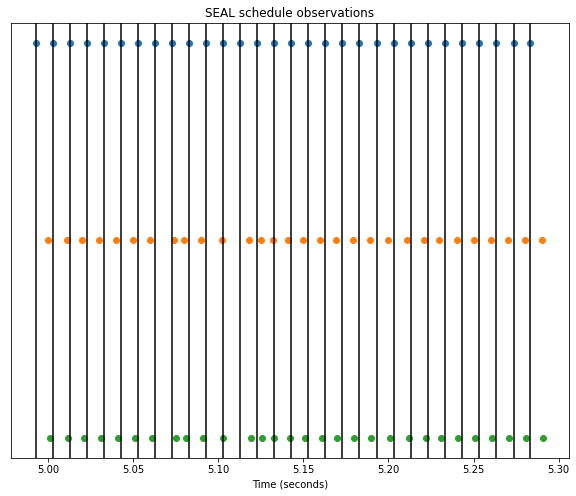

In [327]:
nstart = 500
npoints = 30
plt.figure(figsize=(10,8))
plt.scatter(exposures[nstart:nstart+npoints], 1.5*np.ones_like(exposures[nstart:nstart+npoints]), label="exposures")
plt.scatter(measures[nstart:nstart+npoints], np.ones_like(measures[nstart:nstart+npoints]), label="states")
plt.scatter(dmcs[nstart:nstart+npoints], 0.5*np.ones_like(dmcs[nstart:nstart+npoints]), label="dmcs")
min_time = exposures[nstart]
max_time = dmcs[nstart+npoints-1]
for v in exposures[nstart:nstart+npoints]:
    plt.axvline(v, color='k')
plt.title("SEAL schedule observations")
plt.xlabel("Time (seconds)")
plt.yticks([])
#plt.legend()

In [328]:
len(exposures), len(measures), len(dmcs)

(22006, 22006, 22006)

In [329]:
get_meanstd = lambda data: f"{round(np.mean(data), 3)} $\pm$ {round(np.std(data), 3)}"
measure_delays = (measures - exposures) * fs
num_meas_bins = int(max(measure_delays) * 1000 / fs) + 1
control_delays = (dmcs - measures) * fs
num_cont_bins = int(max(control_delays) * 1000 / fs) + 1
total_delays = (dmcs - exposures) * fs
num_tot_bins = int(max(total_delays) * 1000 / fs) + 1
get_meanstd(measure_delays)

'0.792 $\\pm$ 0.263'

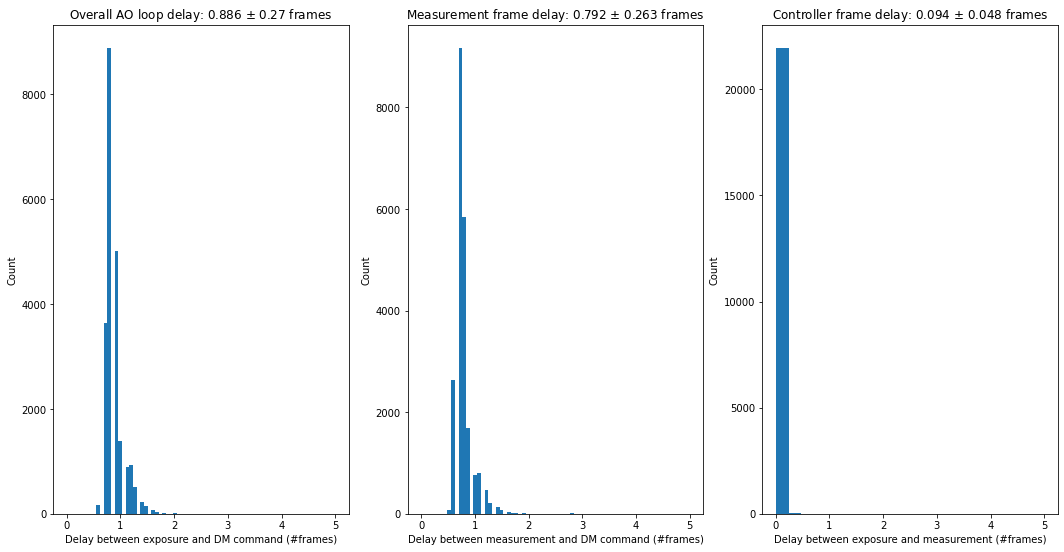

In [331]:
fig, axs = plt.subplots(1,3, figsize=(18,9))
def plot_delay_hist(data, i, xlabel, title):
    bins = int(max(data) * 1000 / fs) + 1
    axs[i].hist(data, bins=min(100, bins), range = (0, min(5, max(total_delays))))
    axs[i].set_xlabel(xlabel)
    axs[i].set_ylabel("Count")
    axs[i].set_title(f"{title}: {get_meanstd(data)} frames")

for (i, (data, xlabel, title)) in enumerate([
    (total_delays, "Delay between exposure and DM command (#frames)", "Overall AO loop delay"),
    (measure_delays, "Delay between measurement and DM command (#frames)", "Measurement frame delay"),
    (control_delays, "Delay between exposure and measurement (#frames)", "Controller frame delay")
]):
    plot_delay_hist(data, i, xlabel, title)
plt.savefig("../plots/seal_delay_analysis.pdf")
plt.savefig("../plots/seal_delay_analysis.png")